# Модуль ML-7. Практика

## Прогнозирование биологического ответа (HW-3)

### Группа DSPR178. Крючков А.В.

### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn-v0_8')

# 1 ПОДГРУЗКА ДАННЫХ

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# зафксируем random_state
random_state = 42

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = random_state, test_size = 0.2)

# 2 ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ МОДЕЛИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

## 2.1 Параметры по умолчанию

Найдем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:


In [64]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
#print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred_lr = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr)))

f1_score на тестовом наборе: 0.78


## 2.2 Подбор гиперпараметров с помощью GridSeachCV

In [ ]:
param_grid_lr = [{'penalty': ['l2', 'none'], #тип регуляризации
              'solver': ['lbfgs', 'sag'], #алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регуляризации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid_lr, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_lr.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_lr.score(X_test, y_test)))
y_test_pred_lr_gs = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr_gs)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

CPU times: total: 2.39 s
Wall time: 3min 50s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


### Итоговые результаты оптимизации гиперпараметров модели логистической регресии с помощью GridSeachCV

In [45]:
print("Наилучшая модель:\n{}".format(grid_search_lr.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')


In [46]:
print("Наилучшая модель:\n{}".format(grid_search_lr.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')


In [47]:
# Наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров)
# – в атрибуте best_score_. 
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_lr.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


In [48]:
# результаты кросс-валидации
result_cv_lr_gs = pd.DataFrame(grid_search_lr.cv_results_)
result_cv_lr_gs.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.537171,0.106594,0.028893,0.012484,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.738333,0.763333,0.78,0.745,0.746667,0.754667,0.015107,13
1,5.552767,1.506125,0.018258,0.002814,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.736667,0.763333,0.78,0.745,0.745000,0.754000,0.015656,15


In [49]:
result_cv_lr_gs.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

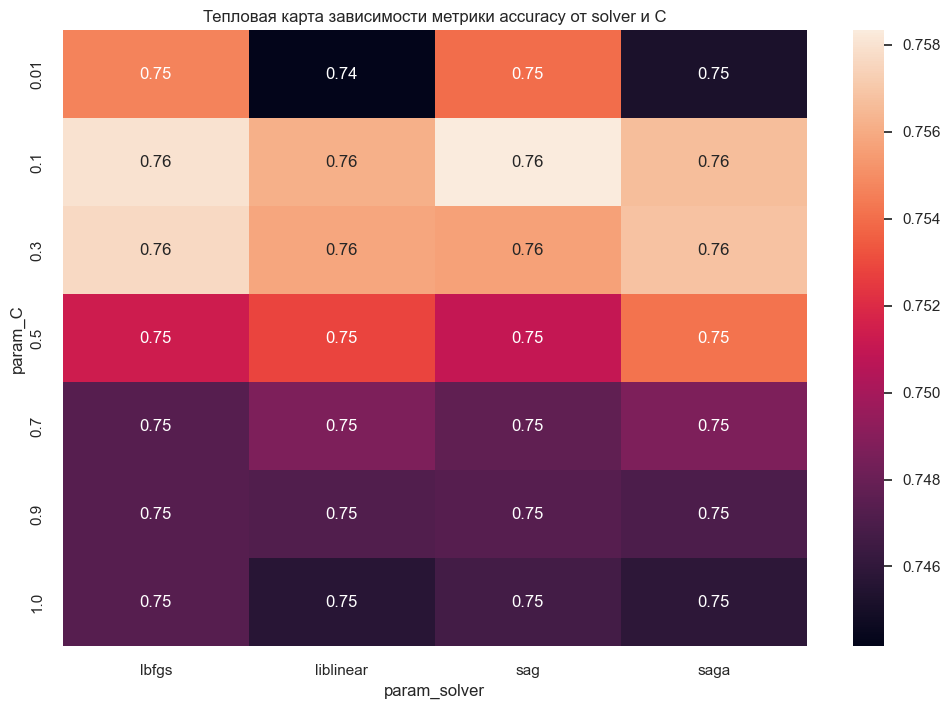

In [50]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual_lr_gs = pd.pivot_table(pd.DataFrame(grid_search_lr.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual_lr_gs, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Лучшие параметры: регуляризация C=0.1, тип регуляризации l2, алгоритм оптимизации 'liblinear'.

Удалось увеличить значение F1 на тестовом наборе до 0.79 по сравнению моделью без оптимизации гиперпараметров.

## 2.3 Подбор гиперпараметров с помощью RandomizedSearchCV

In [ ]:
param_distributions_lr = [{'penalty': ['l2', 'none'], #тип регуляризации
              'solver': ['lbfgs', 'sag'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регуляризации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
            
random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=5000), 
    param_distributions=param_distributions_lr, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_lr.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_lr.score(X_test, y_test)))
y_test_pred_lr_rs = random_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr_rs)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

CPU times: total: 58 s
Wall time: 2min 32s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.34}


Лучшие параметры: регуляризация C=0.34, тип регуляризации l1, алгоритм оптимизации 'saga'.

Удалось увеличить значение F1 на тестовом наборе до 0.79 по сравнению моделью без оптимизации гиперпараметров.

## 2.4 Подбор гиперпараметров с помощью Hyperopt

In [5]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter = 5000)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [9]:
# зададим пространство поиска гиперпараметров
space_lr = hp.choice('reg_type', [
        {'penalty': hp.choice('penalty_0', [None, 'l2']), #тип регуляризации
        'solver': hp.choice('solver_0', ['lbfgs', 'sag']),#алгоритм оптимизации
        'C': hp.uniform('C_0', 0.01, 1)},
        
        {'penalty': hp.choice('penalty_1', ['l1', 'l2']), #тип регуляризации
        'solver': hp.choice('solver_1', ['liblinear', 'saga']), #алгоритм оптимизации
        'C': hp.uniform('C_1', 0.01, 1)}
])

In [10]:
%%time
# начинаем подбор гиперпараметров

trials_lr_hp = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_lr_hp, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )


 10%|█         | 2/20 [00:31<04:01, 13.44s/trial, best loss: -0.780859446781396] 

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 40%|████      | 8/20 [04:53<08:08, 40.73s/trial, best loss: -0.787065257935971]

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 12/20 [10:45<06:58, 52.28s/trial, best loss: -0.7890279343700117]

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



 75%|███████▌  | 15/20 [11:01<01:41, 20.29s/trial, best loss: -0.7890279343700117]

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 19/20 [17:10<00:45, 45.49s/trial, best loss: -0.7897129057797834] 

c:\Users\kryuc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



100%|██████████| 20/20 [17:24<00:00, 52.22s/trial, best loss: -0.7897129057797834]
CPU times: total: 9min 42s
Wall time: 17min 24s


In [11]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'C_1': 0.13679612696710813, 'penalty_1': 0, 'reg_type': 1, 'solver_1': 0}


Наилучшие гиперпараметры penalty='l1', solver='liblinear', C = 0.13679612696710813

In [ ]:
# рассчитаем точность для тестовой выборки с расчитанными гиперпараметрами
model_lr_hp = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty='l1',
    solver='liblinear',
    C=best['C_1']
)
model_lr_hp.fit(X_train, y_train)
y_train_pred_lr_hp = model_lr_hp.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr_hp)))
print("accuracy на тестовом наборе: {:.2f}".format(model_lr_hp.score(X_test, y_test)))
y_test_pred_lr_hp = model_lr_hp.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr_hp)))

f1_score на обучающем наборе: 0.81
accuracy на тестовом наборе: 0.74
f1_score на тестовом наборе: 0.77


### Hyperopt показал ухудшение метрики F1 - 0.77 даже по сравнению с моделью с гиперпараметрами по умолчанию.

## 2.5 Подбор гиперпараметров с помощью Optuna

In [95]:
def optuna_lr(trial, cv=5):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', [None, 'l1', 'l2'])
  if penalty == None:
      solver = trial.suggest_categorical('solver_0', ['lbfgs', 'sag'])
  elif penalty == 'l1':
      solver = trial.suggest_categorical('solver_1', ['liblinear', 'saga'])
  elif penalty == 'l2':
      solver = trial.suggest_categorical('solver_2', ['lbfgs', 'sag', 'liblinear', 'saga'])
  C = trial.suggest_uniform('C', 0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          max_iter = 5000,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
  
  return score

In [96]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=20)

[I 2025-08-08 22:27:53,851] A new study created in memory with name: LogisticRegression
C:\Users\kryuc\AppData\Local\Temp\ipykernel_19296\2380560842.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2025-08-08 22:28:39,146] Trial 0 finished with value: 0.7801602930677343 and parameters: {'penalty': 'l2', 'solver_2': 'sag', 'C': 0.4497988891266175}. Best is trial 0 with value: 0.7801602930677343.
C:\Users\kryuc\AppData\Local\Temp\ipykernel_19296\2380560842.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2025-08-08 22:29:05,803] Trial 1 finished with value: 0.7753872028530591 and parameters: {'penalty': 'l2', 'solv

CPU times: total: 10min 34s
Wall time: 19min 26s


In [97]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver_2': 'lbfgs', 'C': 0.026356013011697942}
f1_score на обучающем наборе: 0.79


In [98]:
best_params_lr_op = study_lr.best_params
for key in best_params_lr_op.keys():
    if 'solver' in key:
        print(key)
        best_params_lr_op['solver'] = best_params_lr_op.pop(key)
        break
print(best_params_lr_op)

solver_2
{'penalty': 'l2', 'C': 0.026356013011697942, 'solver': 'lbfgs'}


In [99]:
# рассчитаем точность для тестовой выборки
model_lr_op = linear_model.LogisticRegression(**best_params_lr_op, random_state=random_state, )
model_lr_op.fit(X_train, y_train)
y_train_pred_lr_op = model_lr_op.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model_lr_op.score(X_test, y_test)))
y_test_pred_lr_op = model_lr_op.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr_op)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


## 2.6 ВЫВОДЫ

В результате подбора гиперараметров на тестовом наборе модели логистической регресии получили следующие значения F1_score:

Без оптимизации - 0.78

GridSeachCV - 0.79

RandomizedSearchCV - 0.79

Hyperopt - 0.77

Optuna - 0.78

Удалось незначительно увеличить показатель F1 на GridSeachCV и RandomizedSearchCV по сравнению с моделью без оптимизации и с гиперпараметрами установленными по умолчанию.

## 3 ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ МОДЕЛИ СЛУЧАЙНОГО ЛЕСА

## 3.1 Параметры по умолчанию

Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [72]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred_rf = rf.predict(X_train)
print('Train F1_score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf)))
y_test_pred_rf = rf.predict(X_test)
print('Test F1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))

Train F1_score: 1.00
Test F1_score: 0.81


## 3.2 Подбор гиперпараметров с помощью GridSeachCV

In [79]:
param_grid_rf = {'n_estimators': list(range(100, 400, 5)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(10, 50, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred_rf_gs = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf_gs)))
#print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred_rf_gs = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_gs)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 17.9 s
Wall time: 11min 51s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 355}


## 3.3 Подбор гиперпараметров с помощью RandomizedSearchCV

In [80]:
param_distributions_rf = {'n_estimators': list(range(100, 400, 5)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(10, 50, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=param_distributions_rf, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred_rf = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf)))
#print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred_rf = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 4.7 s
Wall time: 18 s
f1_score на обучающем наборе: 0.95
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 335, 'min_samples_leaf': 5, 'max_depth': 30}


## 3.4 Подбор гиперпараметров с помощью Hyperopt

In [81]:
# зададим пространство поиска гиперпараметров
space_rf={'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
       'max_depth' : hp.quniform('max_depth', 10, 50, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [84]:
# зафксируем random_state
random_state = random_state
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [85]:
%%time
# начинаем подбор гиперпараметров

trials_rf_ho = Trials() # используется для логирования результатов

best_rf_ho=fmin(hyperopt_rf, # наша функция 
          space=space_rf, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_rf_ho, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf_ho))

100%|██████████| 20/20 [02:34<00:00,  7.74s/trial, best loss: -0.8154851849039776]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 3.0, 'n_estimators': 251.0}
CPU times: total: 1min 15s
Wall time: 2min 34s


In [86]:
# рассчитаем точность для тестовой выборки
model_rf_ho = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf_ho['n_estimators']),
    max_depth=int(best_rf_ho['max_depth']),
    min_samples_leaf=int(best_rf_ho['min_samples_leaf'])
)
model_rf_ho.fit(X_train, y_train)
y_train_pred_rf_ho = model_rf_ho.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf_ho)))
print("accuracy на тестовом наборе: {:.2f}".format(model_rf_ho.score(X_test, y_test)))
y_test_pred_rf_ho = model_rf_ho.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_ho)))

f1_score на обучающем наборе: 0.98
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


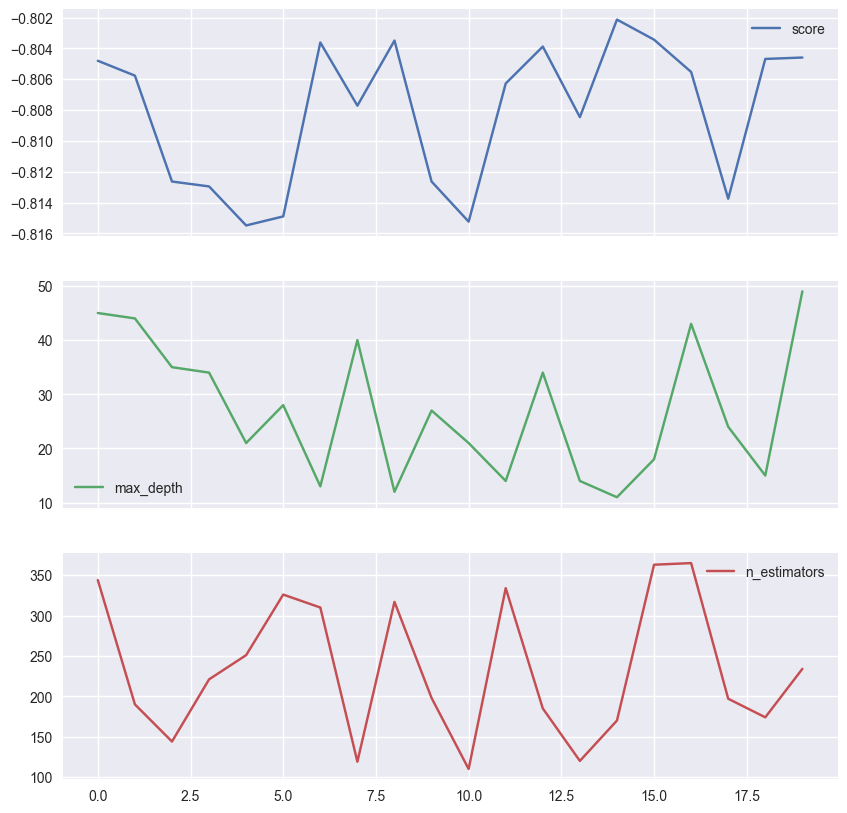

In [87]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_rf_ho.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

## 3.5 Подбор гиперпараметров с помощью Optuna

In [100]:
def optuna_rf(trial, cv=5):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 400, 1)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()

  return score

In [101]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2025-08-08 22:51:41,708] A new study created in memory with name: RandomForestClassifier


C:\Users\kryuc\AppData\Local\Temp\ipykernel_19296\4213976980.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 400, 1)
C:\Users\kryuc\AppData\Local\Temp\ipykernel_19296\4213976980.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
C:\Users\kryuc\AppData\Local\Temp\ipykernel_19296\4213976980.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2025-08-08 22:51:51,853] Trial 0 finished with value: 0.8119206617252429 and parameters: {'n_estimators': 325, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8119206617252429.
C:\Users\kryuc\AppData\Local\Temp\ipyk

CPU times: total: 1min 11s
Wall time: 2min 18s


In [102]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 257, 'max_depth': 41, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [103]:
# рассчитаем точность для тестовой выборки
model_rf_op = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model_rf_op.fit(X_train, y_train)
y_train_pred_rf_op = model_rf_op.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model_rf_op.score(X_test, y_test)))
y_test_pred_rf_op = model_rf_op.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_op)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


In [104]:
optuna.visualization.is_available()

True

In [105]:
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

In [106]:
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")

In [107]:
optuna.visualization.plot_contour(study_rf, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

## 3.6 ВЫВОДЫ

В результате подбора гиперараметров на тестовом наборе модели логистической регресии получили следующие значения F1-score:

Без оптимизации - 0.81

GridSeachCV - 0.80

RandomizedSearchCV - 0.80

Hyperopt - 0.80

Optuna - 0.80

С помощью методов оптимизациин не удалось улучшить показатель F1 н по сравнению с моделью без оптимизации и с гиперпараметрами установленными по умолчанию.

# ОБЩИЕ ВЫВОДЫ

При использовании методов оптимизации гиперпараметров (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) не удалось значительно улучшить результаты в предсказании ответа молекул по их химичесскому составу по сравнению с моделями без оптимизации и с гиперпараметрами установленными по умолчанию, а некоторых случаях показания метрики F1-score учудшились.

 Возможно необходимо дальнейшее изучение этих методов для более правильного их использования.